In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

np.random.seed(42)

In [2]:
# load data
df = pd.read_csv('Health_Sleep_Statistics.csv')

In [3]:
# check for missing values
df.isna().sum()

User ID                    0
Age                        0
Gender                     0
Sleep Quality              0
Bedtime                    0
Wake-up Time               0
Daily Steps                0
Calories Burned            0
Physical Activity Level    0
Dietary Habits             0
Sleep Disorders            0
Medication Usage           0
dtype: int64

In [4]:
df.columns

Index(['User ID', 'Age', 'Gender', 'Sleep Quality', 'Bedtime', 'Wake-up Time',
       'Daily Steps', 'Calories Burned', 'Physical Activity Level',
       'Dietary Habits', 'Sleep Disorders', 'Medication Usage'],
      dtype='object')

In [5]:
df.head()

,User ID,Age,Gender,Sleep Quality,Bedtime,Wake-up Time,Daily Steps,Calories Burned,Physical Activity Level,Dietary Habits,Sleep Disorders,Medication Usage
0,1,25,f,8,23:00,06:30,8000,2500,medium,healthy,no,no
1,2,34,m,7,00:30,07:00,5000,2200,low,unhealthy,yes,yes
2,3,29,f,9,22:45,06:45,9000,2700,high,healthy,no,no
3,4,41,m,5,01:00,06:30,4000,2100,low,unhealthy,yes,no
4,5,22,f,8,23:30,07:00,10000,2800,high,medium,no,no


In [28]:
# Wir filtern 'Sleep Quality' (Target) und 'User ID' (sinnlos) raus
echte_features = [col for col in df.columns if col not in ['Sleep Quality', 'User ID']]

# Erstelle die saubere Tabelle
pd.DataFrame(echte_features, columns=['Feature Name'])

,Feature Name
0,Age
1,Gender
2,Bedtime
3,Wake-up Time
4,Daily Steps
5,Calories Burned
6,Physical Activity Level
7,Dietary Habits
8,Sleep Disorders
9,Medication Usage


In [6]:
df.tail()

,User ID,Age,Gender,Sleep Quality,Bedtime,Wake-up Time,Daily Steps,Calories Burned,Physical Activity Level,Dietary Habits,Sleep Disorders,Medication Usage
95,96,43,m,7,00:45,07:15,6500,2400,medium,medium,no,no
96,97,33,f,8,23:15,06:15,8500,2600,high,medium,no,no
97,98,46,m,4,01:30,07:00,3000,2000,low,unhealthy,yes,yes
98,99,25,f,9,22:15,06:45,9500,2700,high,healthy,no,no
99,100,41,m,6,00:30,07:00,5000,2200,medium,unhealthy,no,no


In [7]:
df.describe()

,User ID,Age,Sleep Quality,Daily Steps,Calories Burned
count,100.000000,100.000000,100.000000,100.000000,100.00000
mean,50.500000,36.010000,7.000000,6830.000000,2421.00000
std,29.011492,8.454865,1.734964,2498.706736,281.06759
min,1.000000,22.000000,4.000000,3000.000000,2000.00000
25%,25.750000,28.750000,5.750000,4750.000000,2175.00000
50%,50.500000,35.000000,7.500000,6750.000000,2400.00000
75%,75.250000,44.000000,8.250000,9000.000000,2700.00000
max,100.000000,50.000000,9.000000,11000.000000,2900.00000


In [29]:
# Zeig mir alle Noten, die vergeben wurden
print(sorted(df['Sleep Quality'].unique()))

[4, 5, 6, 7, 8, 9]


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   User ID                  100 non-null    int64 
 1   Age                      100 non-null    int64 
 2   Gender                   100 non-null    object
 3   Sleep Quality            100 non-null    int64 
 4   Bedtime                  100 non-null    object
 5   Wake-up Time             100 non-null    object
 6   Daily Steps              100 non-null    int64 
 7   Calories Burned          100 non-null    int64 
 8   Physical Activity Level  100 non-null    object
 9   Dietary Habits           100 non-null    object
 10  Sleep Disorders          100 non-null    object
 11  Medication Usage         100 non-null    object
dtypes: int64(5), object(7)
memory usage: 9.5+ KB


In [9]:
# Drop User ID column
df.drop('User ID', axis=1, inplace=True)


# Feature Engineering
df['Gender'] = df['Gender'].map({'f': 0, 'm': 1})
df['Physical Activity Level'] = df['Physical Activity Level'].map({'low': 1, 'medium': 2, 'high': 3})
df['Dietary Habits'] = df['Dietary Habits'].map({'healthy': 1, 'medium': 2, 'unhealthy': 3})
df['Sleep Disorders'] = df['Sleep Disorders'].map({'no': 0, 'yes': 1})
df['Medication Usage'] = df['Medication Usage'].map({'no': 0, 'yes': 1})


# Convert Bedtime and Wake-up Time to numerical format (in hours)
def time_to_hours(time_str):
    hours, minutes = map(int, time_str.split(':'))
    return hours + minutes / 60

df['Bedtime'] = df['Bedtime'].apply(time_to_hours)
df['Wake-up Time'] = df['Wake-up Time'].apply(time_to_hours)

# Create 'Sleep Duration' column
df['Sleep Duration'] = (df['Wake-up Time'] - df['Bedtime']) % 24 

In [10]:
#NEU
# modeling frame: all features

target = 'Sleep Quality'

df_all_tmp = df.copy()
if 'User ID' in df_all_tmp.columns:
    df_all_tmp = df_all_tmp.drop(columns=['User ID'])

features_all = [c for c in df_all_tmp.columns if c != target]

df_model_all = df_all_tmp[features_all + [target]].copy()

print('df_model_all:', df_model_all.shape)
df_model_all.head()

df_model_all: (100, 12)


,Age,Gender,Bedtime,Wake-up Time,Daily Steps,Calories Burned,Physical Activity Level,Dietary Habits,Sleep Disorders,Medication Usage,Sleep Duration,Sleep Quality
0,25,0,23.00,6.50,8000,2500,2,1,0,0,7.5,8
1,34,1,0.50,7.00,5000,2200,1,3,1,1,6.5,7
2,29,0,22.75,6.75,9000,2700,3,1,0,0,8.0,9
3,41,1,1.00,6.50,4000,2100,1,3,1,0,5.5,5
4,22,0,23.50,7.00,10000,2800,3,2,0,0,7.5,8


In [11]:
#NEU2
# modeling frame: low-VIF interpretable features

target = 'Sleep Quality'
features_small = ['Gender', 'Sleep Disorders', 'Medication Usage', 'Sleep Duration']

missing = [c for c in features_small + [target] if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

df_model_small = df[features_small + [target]].copy()

print('df_model_small:', df_model_small.shape)
df_model_small.head()

df_model_small: (100, 5)


,Gender,Sleep Disorders,Medication Usage,Sleep Duration,Sleep Quality
0,0,0,0,7.5,8
1,1,1,1,6.5,7
2,0,0,0,8.0,9
3,1,1,0,5.5,5
4,0,0,0,7.5,8


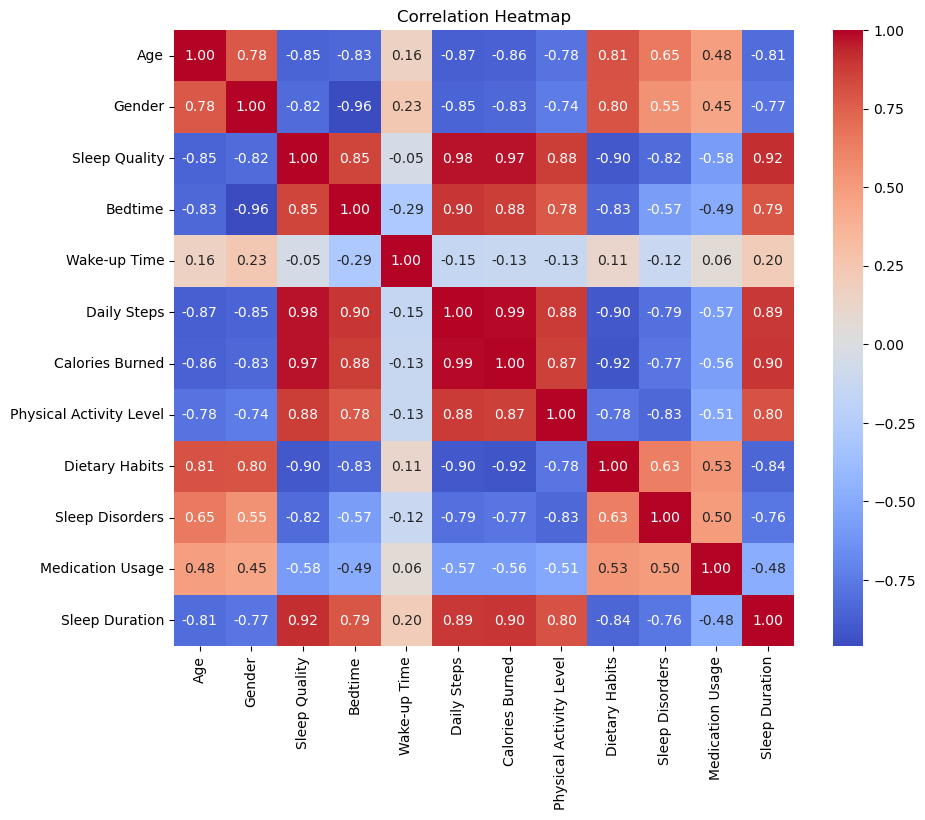

In [12]:
# Correlation Heatmap

corr_data = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_data, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [13]:
# Numerical
corr_data

,Age,Gender,Sleep Quality,Bedtime,Wake-up Time,Daily Steps,Calories Burned,Physical Activity Level,Dietary Habits,Sleep Disorders,Medication Usage,Sleep Duration
Age,1.000000,0.780982,-0.848356,-0.834341,0.157039,-0.873456,-0.861680,-0.777887,0.808083,0.652411,0.483805,-0.810171
Gender,0.780982,1.000000,-0.822584,-0.960791,0.234553,-0.848691,-0.833158,-0.742614,0.797092,0.547153,0.450000,-0.774796
Sleep Quality,-0.848356,-0.822584,1.000000,0.853312,-0.048526,0.976277,0.973557,0.875203,-0.902498,-0.818806,-0.579284,0.918909
Bedtime,-0.834341,-0.960791,0.853312,1.000000,-0.286797,0.896225,0.875811,0.779651,-0.832868,-0.573881,-0.494669,0.789727
Wake-up Time,0.157039,0.234553,-0.048526,-0.286797,1.000000,-0.148297,-0.133275,-0.131566,0.112770,-0.120188,0.058638,0.204076
Daily Steps,-0.873456,-0.848691,0.976277,0.896225,-0.148297,1.000000,0.986750,0.884245,-0.903340,-0.793930,-0.569146,0.890208
Calories Burned,-0.861680,-0.833158,0.973557,0.875811,-0.133275,0.986750,1.000000,0.869424,-0.917775,-0.770047,-0.564974,0.895692
Physical Activity Level,-0.777887,-0.742614,0.875203,0.779651,-0.131566,0.884245,0.869424,1.000000,-0.776253,-0.834831,-0.512148,0.804950
Dietary Habits,0.808083,0.797092,-0.902498,-0.832868,0.112770,-0.903340,-0.917775,-0.776253,1.000000,0.629967,0.531395,-0.843568
Sleep Disorders,0.652411,0.547153,-0.818806,-0.573881,-0.120188,-0.793930,-0.770047,-0.834831,0.629967,1.000000,0.501557,-0.763727


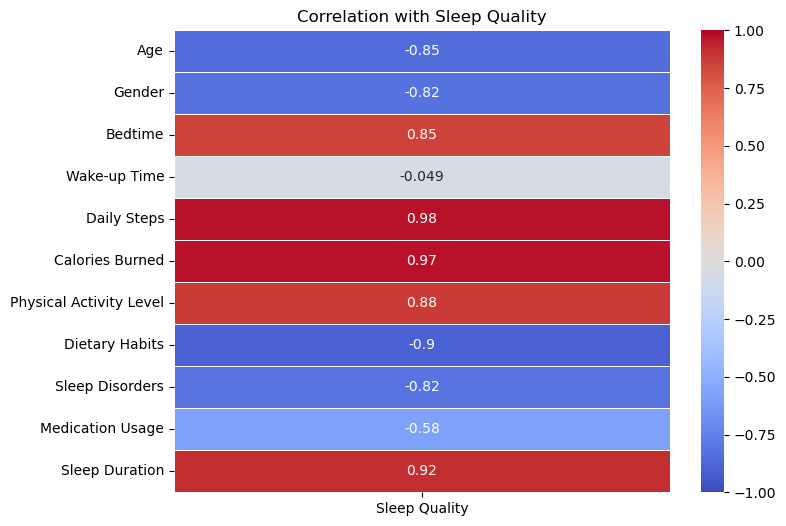

In [14]:
# correlation with target
correlation_with_target = df.corr()['Sleep Quality'].drop('Sleep Quality')  # Drop self-correlation

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_with_target.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation with Sleep Quality')
plt.show()

In [15]:
# numerical
correlation_with_target.abs().sort_values(ascending=False)

Daily Steps                0.976277
Calories Burned            0.973557
Sleep Duration             0.918909
Dietary Habits             0.902498
Physical Activity Level    0.875203
Bedtime                    0.853312
Age                        0.848356
Gender                     0.822584
Sleep Disorders            0.818806
Medication Usage           0.579284
Wake-up Time               0.048526
Name: Sleep Quality, dtype: float64

$$\text{Skewness} = \frac{n}{(n-1)(n-2)} \sum_{i=1}^{n} \left( \frac{x_i - \bar{x}}{s} \right)^3$$

- measures the asymmetry of a data distribution
- values close to 0 indicate a symmetric distribution, positive values indicate a right-skewed (long tail on the right), and negative values indicate a left-skewed distribution.

$$\text{Kurtosis} = \frac{n(n+1)}{(n-1)(n-2)(n-3)} \sum_{i=1}^{n} \left( \frac{x_i - \bar{x}}{s} \right)^4 - \frac{3(n-1)^2}{(n-2)(n-3)}$$

- measures the "tailedness" of a distribution
- high kurtosis indicating heavy tails (more outliers) and low kurtosis indicating light tails (fewer outliers) vs a normal distribution (kurtosis of 0 when using excess kurtosis).


In [16]:
# Skewness and Kurtosis
skewness_kurtosis = pd.DataFrame({
    'Skewness': df.skew(),
    'Kurtosis': df.kurt()
})

skewness_kurtosis


,Skewness,Kurtosis
Age,0.167786,-1.308221
Gender,0.000000,-2.041237
Sleep Quality,-0.426305,-1.176617
Bedtime,0.000737,-2.034177
Wake-up Time,-0.473496,-0.683608
Daily Steps,-0.218371,-1.434135
Calories Burned,-0.089541,-1.364569
Physical Activity Level,-0.179009,-1.349230
Dietary Habits,-0.229899,-1.521601
Sleep Disorders,1.111041,-0.781627


**Variance Inflation Factor (VIF)**

$$\text{VIF}_{i} = \frac{1}{1 - R_i^2}$$

- measures how much the variance of a regression coefficient is inflated due to multicollinearity with other predictors
- VIF > than 5 or 10 typically shows high multicollinearity suggesting that the feature is highly correlated with others and may need to be removed.


In [17]:
# VIF

# 1) Build X_vif from df
X_vif = df[['Age','Gender','Daily Steps','Calories Burned','Physical Activity Level',
            'Dietary Habits','Sleep Disorders','Medication Usage','Sleep Duration']]

# 2) Add intercept
X_vif = sm.add_constant(X_vif)

# 3) Compute VIFs
vif_data = pd.DataFrame({
    'Feature': X_vif.columns,
    'VIF': [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})

# 4) Hide the intercept row
vif_data = vif_data[vif_data['Feature'] != 'const'].reset_index(drop=True)
vif_data

,Feature,VIF
0,Age,4.536181
1,Gender,4.705075
2,Daily Steps,56.677755
3,Calories Burned,47.572039
4,Physical Activity Level,6.207480
5,Dietary Habits,7.478360
6,Sleep Disorders,5.549000
7,Medication Usage,1.530620
8,Sleep Duration,6.288497


C:\Users\leon\AppData\Local\Temp\ipykernel_9464\2113938094.py:10: UserWarning: 
The palette list has fewer values (3) than needed (9) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='VIF', y='Feature', data=vif_data, hue='Feature', palette=custom_colors, legend=False)


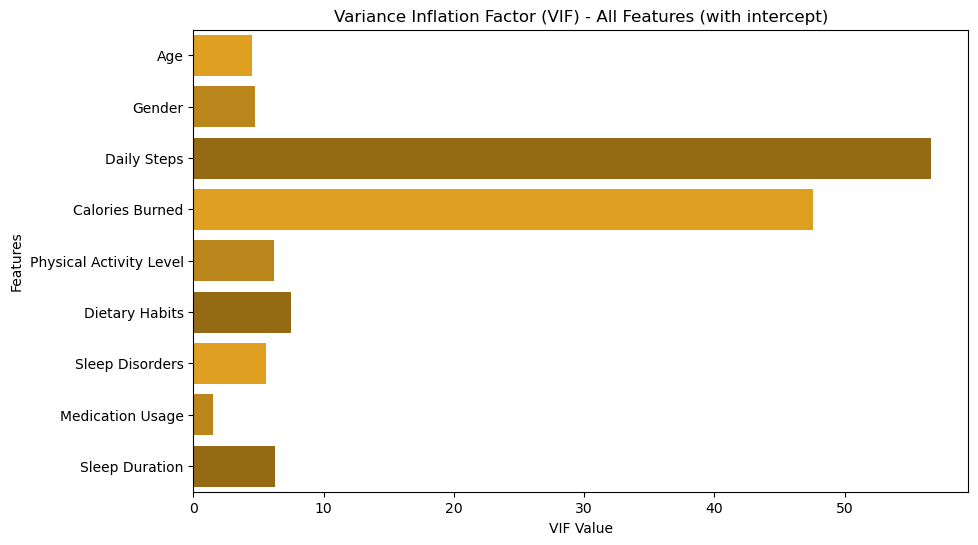

In [30]:
# Plotting the VIF values
import matplotlib.pyplot as plt
import seaborn as sns

# Deine definierte Farbpalette
custom_colors = ['#FFAA00', '#D48E00', '#AA7100']

plt.figure(figsize=(10, 6))
# palette="Blues_d" wurde durch custom_colors ersetzt
sns.barplot(x='VIF', y='Feature', data=vif_data, hue='Feature', palette=custom_colors, legend=False)
plt.title("Variance Inflation Factor (VIF) - All Features (with intercept)")
plt.xlabel("VIF Value")
plt.ylabel("Features")
plt.show()

In [19]:
# Iteratively remove features with the highest VIF values until all remaining features have VIF < 10
def calculate_vif(X):
    # Compute VIF with an intercept and hide the intercept row
    Xc = sm.add_constant(X)
    vif = pd.DataFrame({
        'Feature': Xc.columns,
        'VIF': [variance_inflation_factor(Xc.values, i) for i in range(Xc.shape[1])]
    })
    vif = vif[vif['Feature'] != 'const'].reset_index(drop=True)
    return vif

# Initial VIF calculation
X_vif_reduced = X_vif.copy()
vif_data_reduced = calculate_vif(X_vif_reduced)

# Removing features with VIF > 10 iteratively
while vif_data_reduced['VIF'].max() > 5:
    # Remove the feature with the highest VIF
    feature_to_remove = vif_data_reduced.sort_values(by='VIF', ascending=False).iloc[0]['Feature']
    X_vif_reduced = X_vif_reduced.drop(columns=[feature_to_remove])
    vif_data_reduced = calculate_vif(X_vif_reduced)

vif_data_reduced

,Feature,VIF
0,Age,3.721235
1,Gender,3.222472
2,Dietary Habits,3.946386
3,Sleep Disorders,1.945359
4,Medication Usage,1.491225


In [20]:
# take the 5 low-VIF candidates from the table you just computed
cands = vif_data_reduced['Feature'].tolist()

# choose the 4 with the strongest |corr| to Sleep Quality
top4 = (df[cands + ['Sleep Quality']]
        .corr()['Sleep Quality'].abs()
        .drop('Sleep Quality')
        .sort_values(ascending=False)
        .head(4)
        .index.tolist())

selected4 = top4
X_sm = df[selected4]
y    = df['Sleep Quality']
print("Selected 4 features:", selected4)

Selected 4 features: ['Dietary Habits', 'Age', 'Gender', 'Sleep Disorders']


**Feature selection (4 features) — rationale**

- Selection is **data-driven**, not random:  
  1) keep variables with **low multicollinearity** (VIF < 5), and  
  2) among those, pick the **top 4 by absolute correlation** with *Sleep Quality*.
- This balances stability (low VIF) with predictive relevance (high |corr|).
- Final chosen features: `Gender, Sleep Disorders, Medication Usage, Sleep Duration.`

In [21]:
# Keep the 4 selected features (from the previous cell: `selected4`)
X_vif_refined = X_vif[selected4].copy()

# Recalculate VIF on these 4
vif_data_refined = calculate_vif(X_vif_refined)
vif_data_refined


,Feature,VIF
0,Dietary Habits,3.799731
1,Age,3.719226
2,Gender,3.221473
3,Sleep Disorders,1.839933


C:\Users\leon\AppData\Local\Temp\ipykernel_9464\1708602241.py:10: UserWarning: 
The palette list has fewer values (3) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='VIF', y='Feature', data=vif_data_refined, hue='Feature', palette=custom_colors, legend=False)


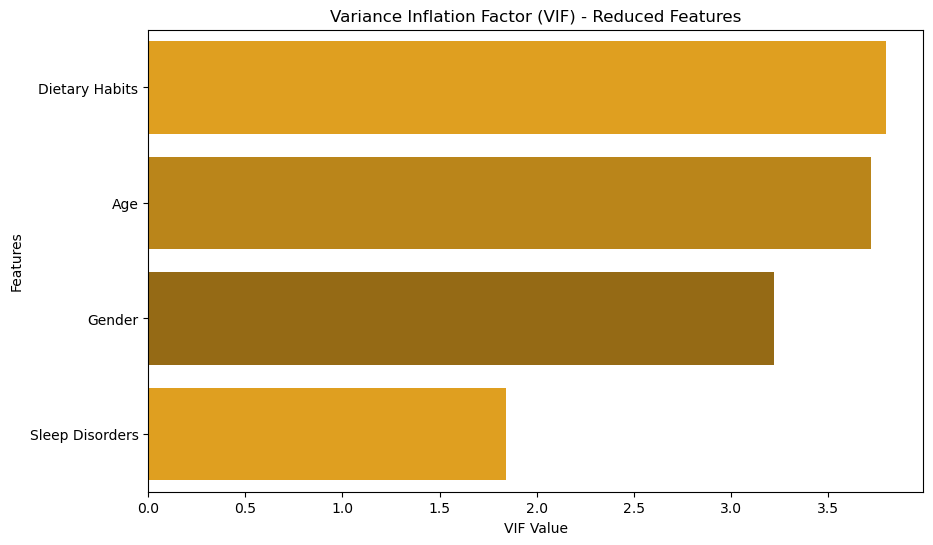

In [31]:
# Plotting the reduced VIF values
import matplotlib.pyplot as plt
import seaborn as sns

# Deine definierte Farbpalette
custom_colors = ['#FFAA00', '#D48E00', '#AA7100']

plt.figure(figsize=(10, 6))
# palette="Blues_d" wurde durch custom_colors ersetzt
sns.barplot(x='VIF', y='Feature', data=vif_data_refined, hue='Feature', palette=custom_colors, legend=False)
plt.title("Variance Inflation Factor (VIF) - Reduced Features")
plt.xlabel("VIF Value")
plt.ylabel("Features")
plt.show()

In [23]:
df[selected4 + ['Sleep Quality']].corr()['Sleep Quality'].drop('Sleep Quality').sort_values(ascending=False)

corr_view = (
    df[selected4 + ['Sleep Quality']]
      .corr()['Sleep Quality']
      .drop('Sleep Quality')
      .rename('corr_to_sleep')
      .sort_values(ascending=False)
      .round(3)
)
corr_view.to_frame()

,corr_to_sleep
Sleep Disorders,-0.819
Gender,-0.823
Age,-0.848
Dietary Habits,-0.902


In [24]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


X = df[['Age', 'Gender', 'Daily Steps', 'Calories Burned', 'Physical Activity Level', 
             'Dietary Habits', 'Sleep Disorders', 'Medication Usage', 'Sleep Duration']]

# Standardizing 
X_scaled = scaler.fit_transform(X)

# Apply PCA 
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Checking how much variance is explained by each component
explained_variance = pca.explained_variance_ratio_

explained_variance_full_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(explained_variance))],
    'Explained Variance Ratio': explained_variance
})

explained_variance_full_df

,Principal Component,Explained Variance Ratio
0,PC1,0.781918
1,PC2,0.074848
2,PC3,0.058347
3,PC4,0.024607
4,PC5,0.022781
5,PC6,0.017891
6,PC7,0.011236
7,PC8,0.007217
8,PC9,0.001156


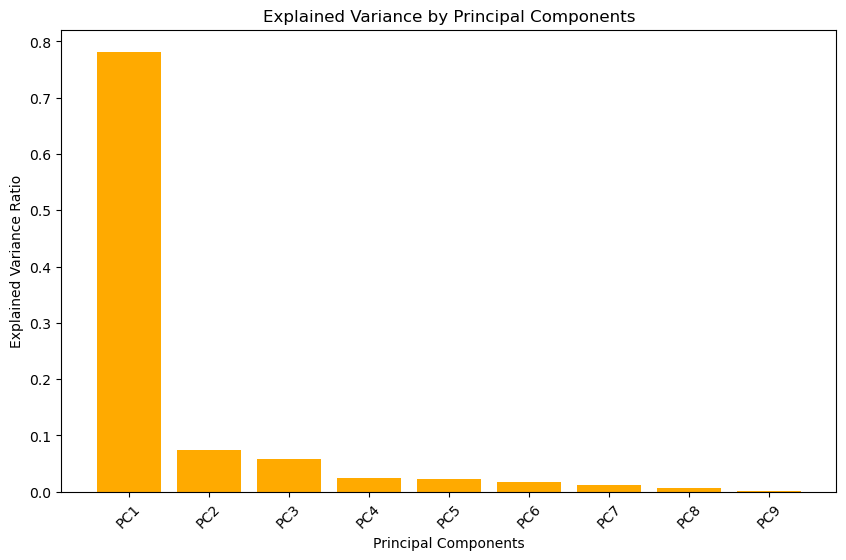

In [32]:
# explained variance ratio for each PC
plt.figure(figsize=(10, 6))
plt.bar(x=explained_variance_full_df['Principal Component'], height=explained_variance_full_df['Explained Variance Ratio'], color='#FFAA00')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(rotation=45)
plt.show()

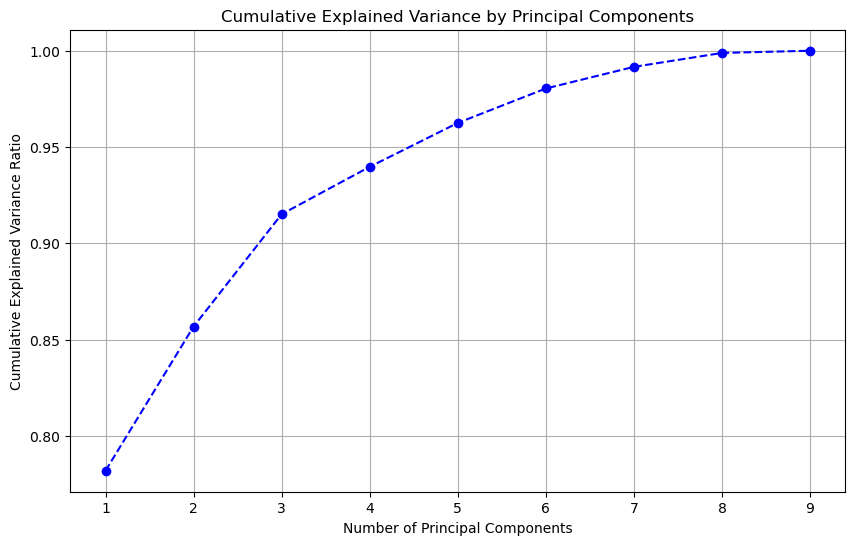

In [26]:
# cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), marker='o', linestyle='--', color='b')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()